In [1]:
import os

DATASET_PATH = r"C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG"


print("🔍 Checking Dataset Path...")
print(os.listdir(DATASET_PATH)[:5])

🔍 Checking Dataset Path...
['BraTS19_2013_10_1', 'BraTS19_2013_11_1', 'BraTS19_2013_12_1', 'BraTS19_2013_13_1', 'BraTS19_2013_14_1']


In [2]:
from torch.utils.data import Dataset, DataLoader
import os, glob
import torch
import numpy as np
import nibabel as nib
import torch.nn.functional as F
from torchvision import transforms

class BraTSDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.modalities = ["flair", "t1", "t1ce", "t2"]

        all_patients = sorted(os.listdir(dataset_path))
        self.patients = []

        for patient in all_patients:
            patient_path = os.path.join(dataset_path, patient)
            try:
                # Try to load one slice to validate
                _ = [self.load_nii(patient_path, mod) for mod in self.modalities]
                _ = self.load_nii(patient_path, "seg")
                self.patients.append(patient)
            except:
                print(f"⚠️ Skipping {patient} in init due to missing files")

    def __len__(self):
        return len(self.patients)

    def load_nii(self, patient_folder, modality):
        possible_files = glob.glob(os.path.join(patient_folder, f"*{modality}*.nii*"))

        if not possible_files and modality == "t1":
            possible_files = glob.glob(os.path.join(patient_folder, f"*ROI*{modality}*.nii*"))

        if not possible_files:
            raise FileNotFoundError(f"❌ No file found for modality '{modality}' in {patient_folder}")

        possible_files.sort(key=lambda x: x.endswith(".gz"), reverse=True)
        file_path = possible_files[0]

        print(f"✅ Loading: {file_path}")
        return nib.load(file_path).get_fdata()

    def __getitem__(self, idx):
        patient = self.patients[idx]
        patient_path = os.path.join(self.dataset_path, patient)

        try:
            images = [self.load_nii(patient_path, mod) for mod in self.modalities]
            images = np.stack(images, axis=0)

            mask = self.load_nii(patient_path, "seg")
            slice_idx = mask.shape[-1] // 2
            image = images[:, :, :, slice_idx]
            mask = mask[:, :, slice_idx]

            image_tensor = torch.tensor(image, dtype=torch.float32)
            mask_tensor = torch.tensor(mask, dtype=torch.long)

            image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)
            mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0).float()
            mask_tensor = F.interpolate(mask_tensor, size=(224, 224), mode="nearest").squeeze(0).squeeze(0).long()

            print(f"✅ Loaded {patient}: Image {image_tensor.shape}, Mask {mask_tensor.shape}")
            return image_tensor, mask_tensor

        except FileNotFoundError as e:
            print(f"⚠️ Skipping {patient} due to missing files: {e}")
            return None

# ➕ Custom collate_fn to skip Nones in batches
def skip_none_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        # Return dummy tensors so training doesn't crash
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    return torch.utils.data.dataloader.default_collate(batch)

In [3]:
import glob
import torch.nn.functional as F

# Load Dataset
train_dataset = BraTSDataset(DATASET_PATH)

valid_samples = [d for d in train_dataset if d is not None]


if len(valid_samples) == 0:
    raise ValueError("❌ No valid samples found. Check dataset paths and file integrity.")


#train_loader = DataLoader(valid_samples, batch_size=2, shuffle=True, num_workers=0)
train_loader = DataLoader(valid_samples, batch_size=4, shuffle=True, collate_fn=skip_none_collate, num_workers=0)
print(f"✅ Loaded {len(train_loader.dataset)} valid patients from BraTS 2019.")

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\aryashah2k\brain-tumor-segmentation-brats-2019\versions\1\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_seg.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\ary

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.swin_transformer import swin_tiny_patch4_window7_224 as SwinTransformer


class MultiScaleAttentionFusion(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleAttentionFusion, self).__init__()

        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 4, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

        self.spatial_attn = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        c_attn = self.channel_attn(x)
        x = x * c_attn
        s_attn = self.spatial_attn(x)
        x = x * s_attn
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


class SwinUNet(nn.Module):
    def __init__(self, img_size=224, in_channels=4, out_channels=4):
        super(SwinUNet, self).__init__()

        self.swin = SwinTransformer(pretrained=True)
        self.swin.head = nn.Identity()
        self.swin.patch_embed.proj = nn.Conv2d(in_channels, 96, kernel_size=4, stride=4, padding=0)

        self.attn1 = MultiScaleAttentionFusion(768)
        self.attn2 = MultiScaleAttentionFusion(384)
        self.attn3 = MultiScaleAttentionFusion(192)
        self.attn4 = MultiScaleAttentionFusion(96)

        self.up1 = UpBlock(768, 384, 384)
        self.up2 = UpBlock(384, 192, 192)
        self.up3 = UpBlock(192, 96, 96)
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(96, out_channels, kernel_size=2, stride=2)
        )

        # Deep supervision outputs
        self.aux_out1 = nn.Conv2d(384, out_channels, kernel_size=1)
        self.aux_out2 = nn.Conv2d(192, out_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.swin.patch_embed(x)
        x = self.swin.patch_embed.norm(x)
        x = self.swin.layers[0](x)
        x1 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[1](x)
        x2 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[2](x)
        x3 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[3](x)
        x4 = x.permute(0, 3, 1, 2)

        # Apply attention to skip features
        x1 = self.attn4(x1)
        x2 = self.attn3(x2)
        x3 = self.attn2(x3)
        x4 = self.attn1(x4)

        # Decoder with skip connections
        x = self.up1(x4, x3)
        aux1 = self.aux_out1(x)
        x = self.up2(x, x2)
        aux2 = self.aux_out2(x)
        x = self.up3(x, x1)
        x = self.up4(x)

        return x, aux1, aux2


# Loss Functions
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Resize target if shape mismatch
        if pred.shape[2:] != target.shape[1:]:
            target = F.interpolate(target.unsqueeze(1).float(), size=pred.shape[2:], mode="nearest").squeeze(1).long()

        # Assert class values are within range
        assert target.max() < pred.shape[1], f"Target has class {target.max().item()} >= num_classes {pred.shape[1]}"

        pred = torch.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        intersection = (pred * target_one_hot).sum(dim=dims)
        union = pred.sum(dim=dims) + target_one_hot.sum(dim=dims)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


import torch.nn.functional as F

def combined_loss(preds, target):
    main_pred, aux1, aux2 = preds

    # Resize target to match the main_pred size (112x112)
    target_resized = F.interpolate(target.unsqueeze(1).float(), size=main_pred.shape[2:], mode="nearest").squeeze(1).long()

    # Debugging: Ensure target values are within the expected range
    assert torch.min(target_resized) >= 0 and torch.max(target_resized) < 4, "Target values must be in the range [0, 3]"
    print(f"Resized target min/max: {torch.min(target_resized)} / {torch.max(target_resized)}")
    
    # Dice + CrossEntropy for main prediction
    dice_loss = SoftDiceLoss()(main_pred, target_resized)
    ce_loss = nn.CrossEntropyLoss(
        weight=torch.tensor([0.1, 1.0, 1.0, 3.0]).to(main_pred.device)
    )(main_pred, target_resized)

    # Resize target to match aux1 and aux2 sizes
    target_aux1 = F.interpolate(target.unsqueeze(1).float(), size=aux1.shape[2:], mode="nearest").squeeze(1).long()
    target_aux2 = F.interpolate(target.unsqueeze(1).float(), size=aux2.shape[2:], mode="nearest").squeeze(1).long()

    # Auxiliary losses
    aux1_loss = nn.CrossEntropyLoss()(aux1, target_aux1)
    aux2_loss = nn.CrossEntropyLoss()(aux2, target_aux2)

    # Total loss: Weighted sum
    total_loss = dice_loss + ce_loss + 0.5 * aux1_loss + 0.5 * aux2_loss
    return total_loss



# Test
if __name__ == "__main__":
    device = "cpu"
    model = SwinUNet().to(device)
    dummy_input = torch.randn(2, 4, 224, 224).to(device)
    outputs = model(dummy_input)
    print("✅ Refactored Swin-UNet Forward Pass Successful! Output shape:", outputs[0].shape)

✅ Refactored Swin-UNet Forward Pass Successful! Output shape: torch.Size([2, 4, 112, 112])


In [7]:
model = SwinUNet().to(device)
model.load_state_dict(torch.load(r"C:\Users\Dell\Desktop\Group_4_sem_6_AIML\saved model\2018_combined_loss_finetuned_lgg.pth"))
print("✅ Loaded pretrained weights from 2018_lgg dataset")

✅ Loaded pretrained weights from 2018_lgg dataset


In [9]:
import torch.optim as optim

Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shape: torch.Size([4, 224, 224]), Max target value: 3
Resized target min/max: 0 / 3
Output shape: torch.Size([4, 4, 224, 224]), Target shap

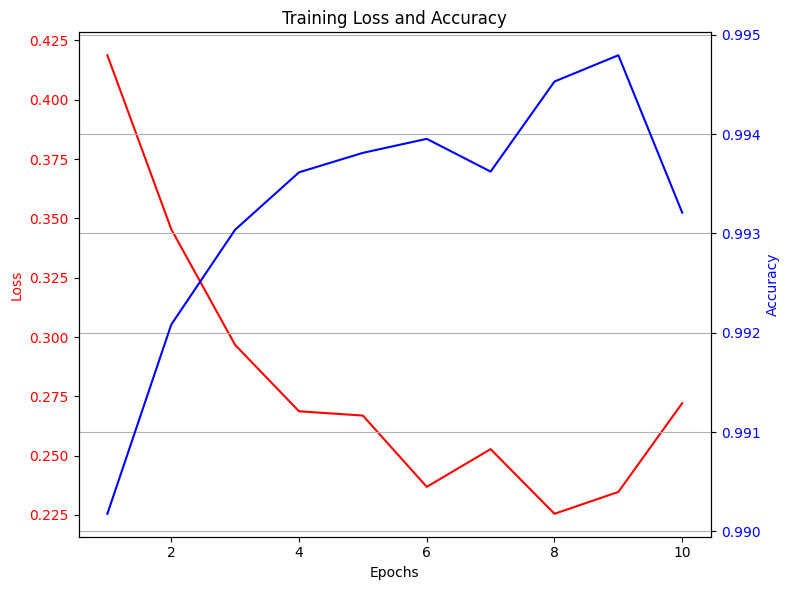

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialize lists to store loss and accuracy
epoch_losses = []
epoch_accuracies = []

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    valid_batches = 0

    for batch in train_loader:
        if batch is None:
            print("⚠️ Skipping an invalid batch.")
            continue

        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        if targets.max() >= 4:
            targets = torch.clamp(targets, 0, 3)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Resize outputs
        main_pred, aux1, aux2 = outputs
        main_pred = F.interpolate(main_pred, size=(224, 224), mode='bilinear', align_corners=False)
        aux1 = F.interpolate(aux1, size=(224, 224), mode='bilinear', align_corners=False)
        aux2 = F.interpolate(aux2, size=(224, 224), mode='bilinear', align_corners=False)

        print(f"Output shape: {main_pred.shape}, Target shape: {targets.shape}, Max target value: {targets.max()}")

        # Compute the loss
        loss = combined_loss([main_pred, aux1, aux2], targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        valid_batches += 1

        # Accuracy: compare argmax of predictions to targets
        pred_class = torch.argmax(main_pred, dim=1)
        correct_pixels += (pred_class == targets).sum().item()
        total_pixels += targets.numel()

    if valid_batches > 0:
        avg_loss = running_loss / valid_batches
        accuracy = correct_pixels / total_pixels
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"✅ Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    else:
        print(f"❌ No valid batches in epoch {epoch+1}!")

# After training, plot loss and accuracy on one graph
def plot_loss_accuracy(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="red")
    ax1.plot(epochs, losses, color="red", label="Loss")
    ax1.tick_params(axis='y', labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="blue")
    ax2.plot(epochs, accuracies, color="blue", label="Accuracy")
    ax2.tick_params(axis='y', labelcolor="blue")

    plt.title("Training Loss and Accuracy")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_loss_accuracy(epoch_losses, epoch_accuracies)

In [7]:
torch.save(model.state_dict(), "2019_combined_loss_finetuned_hgg.pth")
print("✅ Fine-tuning complete. Model saved.")

✅ Fine-tuning complete. Model saved.
